# I. Preparation

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from nn_interpretability.interpretation.am.general_am import ActivationMaximization
from nn_interpretability.interpretation.am.am_in_codespace import ActivationMaximizationCodespace
from nn_interpretability.model.model_trainer import ModelTrainer
from nn_interpretability.model.model_repository import ModelRepository
from nn_interpretability.visualization.mnist_visualizer import MnistVisualizer
from nn_interpretability.dataset.mnist_data_loader import MnistDataLoader

In [2]:
mnist_data_loader = MnistDataLoader()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

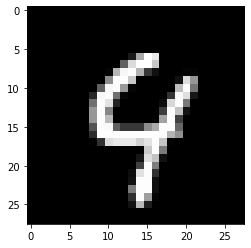

In [3]:
MnistVisualizer.show_dataset_examples(mnist_data_loader.trainloader)

# II. General Activation Maximization

The goal of ActivNation Maximization is to find an input which produces the highest model output for a given class. This reduces to the following optimization process.

![Activation Maximization Formula](./assets/activation_maximization_formula.png)

Our implementation is based on the paper "Methods for Interpreting and Understanding Deep Neural Networks
" by Montavon et al, which can be accessed [here.](https://arxiv.org/pdf/1706.07979.pdf) We consider three starting points:

1. Random image from dataset
2. Random noise
3. Mean class image

In [4]:
model_name = 'model_cnn.pt'
train = False
model = ModelRepository.get_general_mnist_cnn(model_name)

if train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    model.train()
    ModelTrainer.train(model, criterion, optimizer, mnist_data_loader.trainloader, 1)
    
    ModelRepository.save(model, model_name)

## 1. AM from random image for each class

In the first case, we randomly draw an image from the dataset for each class and start the optimization process from there.

In [5]:
img_shape = (28, 28)
lr = 0.005
reg_term = 1e-3
epochs = 1000

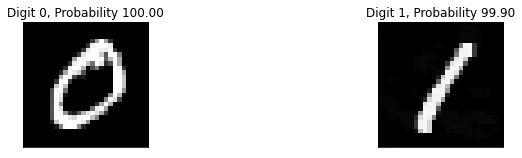

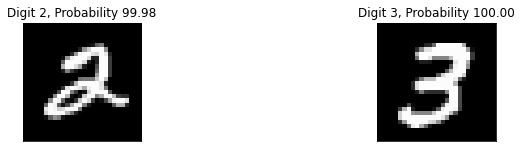

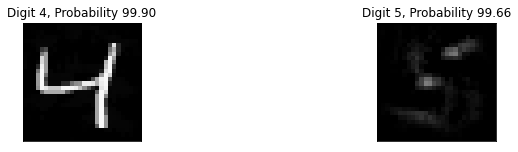

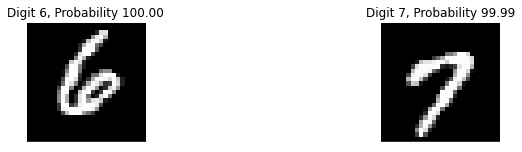

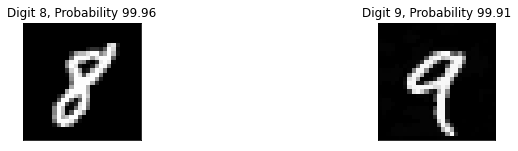

In [6]:
images = []
probabilities = []

for i in range(10):
    img = mnist_data_loader.get_image_for_class(i).expand(1, 1, 28, 28).to(device)
    mean_img = mnist_data_loader.generate_mean_image_for_class(i).expand(1, 1, 28, 28).to(device)
    
    interpretor = ActivationMaximization(model, [], None, img_shape, img, i,  lr, reg_term, mean_img, epochs, threshold=0.999)
    end_point = interpretor.interpret()
    
    scores = model(end_point.to(device)).to(device)
    prob = torch.nn.functional.softmax(scores, 1)[0][i] * 100
    probabilities.append(prob)
    
    images.append(end_point.reshape(img_shape))

MnistVisualizer.display_images_with_probabilities_for_each_class(images, probabilities)

## 2.1. AM from random noise with class mean image as regularization

In the second case, we start the optimization process from random noise with class mean image as regularization.

In [7]:
img_shape = (28, 28)
lr = 5e-3
reg_term = 1e-2
epochs = 10000

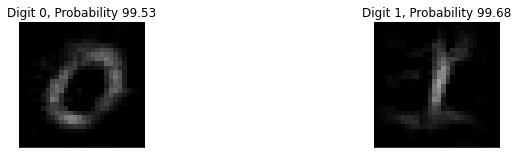

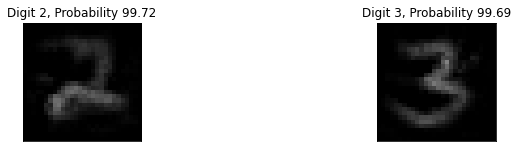

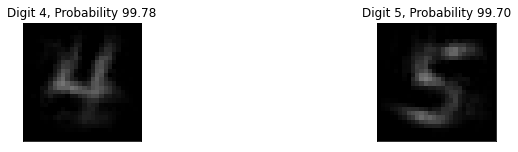

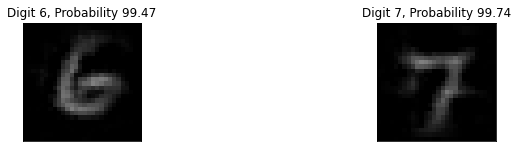

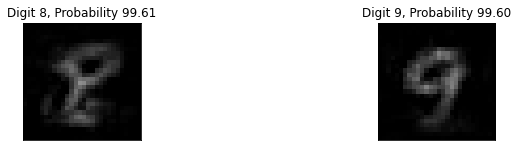

In [8]:
images = []
probabilities = []

for i in range(10):
    image_noise = torch.rand((1, 1, 28, 28)).to(device)
    mean = mnist_data_loader.generate_mean_image_for_class(i).expand(1, 1, 28, 28).to(device)
    
    interpretor = ActivationMaximization(model, [], None, img_shape, image_noise, i,  lr, reg_term, mean, epochs, False, 0.999)
    endpoint = interpretor.interpret()
    
    scores = model(endpoint.to(device)).to(device)
    prob = torch.nn.functional.softmax(scores, 1)[0][i] * 100
    probabilities.append(prob)
    
    images.append(endpoint.reshape(img_shape))

MnistVisualizer.display_images_with_probabilities_for_each_class(images, probabilities)

## 2.2. AM from random noise with L2 regularization

In the second case, we start the optimization process from random noise with L2 regularization.

In [9]:
img_shape = (28, 28)
lr = 5e-3
reg_term = 1e-1
epochs = 10000

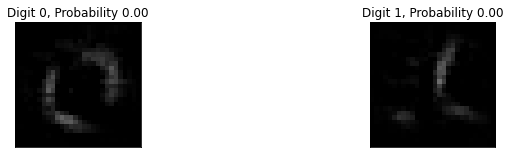

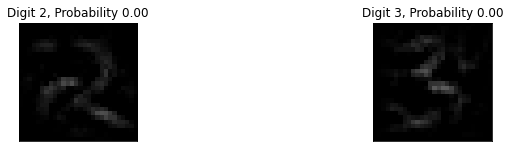

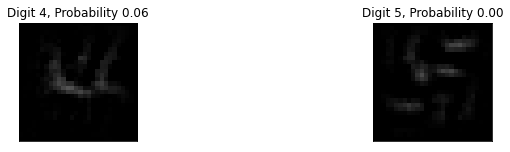

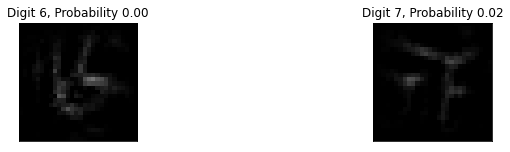

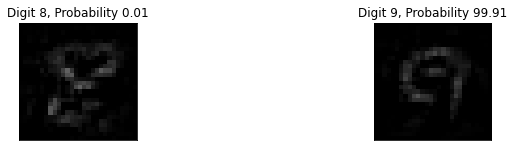

In [10]:
images = []
probabilities = []

for i in range(10):
    image_noise = torch.rand((1, 1, 28, 28)).to(device)
    mean = torch.zeros((1, 1, 28, 28)).to(device)
    
    interpretor = ActivationMaximization(model, [], None, img_shape, image_noise, i,  lr, reg_term, mean, epochs, False, 0.999)
    endpoint = interpretor.interpret()
    
    scores = model(end_point.to(device)).to(device)
    prob = torch.nn.functional.softmax(scores, 1)[0][i] * 100
    probabilities.append(prob)
    
    images.append(endpoint.reshape(img_shape))

MnistVisualizer.display_images_with_probabilities_for_each_class(images, probabilities)

## 3. AM from mean image of class

In the third and final case, we start from the mean image class.

In [29]:
img_shape = (28, 28)
lr = 6e-6
reg_term = 8e-2
epochs = 1000

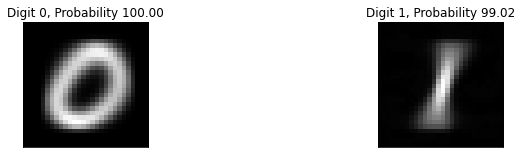

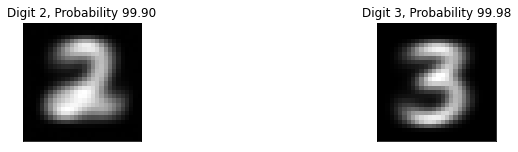

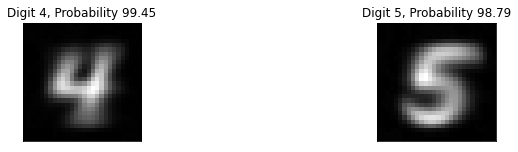

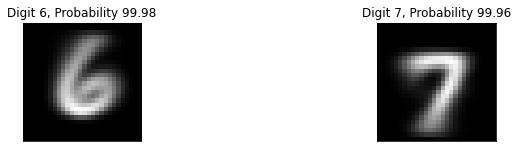

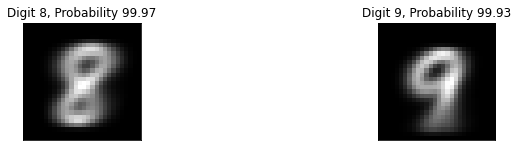

In [30]:
images = []
probabilities = []

for i in range(10):
    img = mnist_data_loader.generate_mean_image_for_class(i).expand(1, 1, 28, 28).to(device)
    mean = torch.zeros((1, 1, 28, 28)).to(device)
    
    interpretor = ActivationMaximization(model, [], None, img_shape, img, i,  lr, reg_term, mean, epochs, threshold=0.999)
    end_point = interpretor.interpret()
    end_point = (end_point - end_point.min()) / (end_point.max() - end_point.min())
    
    scores = model(end_point.to(device)).to(device)
    prob = torch.nn.functional.softmax(scores, 1)[0][i] * 100
    probabilities.append(prob)

    images.append(end_point.reshape(img_shape))

MnistVisualizer.display_images_with_probabilities_for_each_class(images, probabilities)

# III. Activation Maximization in Codespace

Activation Maximization in Codespace is an extension to the Activation Maximization idea by introducing a generative model which generates the input to be fed into the main model. Our implementation is based once again on the paper "Methods for Interpreting and Understanding Deep Neural Networks
" by Montavon et al, which can be accessed [here.](https://arxiv.org/pdf/1706.07979.pdf)

![Activation Maximization in Codespace Formula](./assets/activation_maximization_codespace_formula.png)

 We consider two different starting points:

1. Simple GAN
2. Pretrained DCGAN (source: https://github.com/csinva/gan-vae-pretrained-pytorch)

## 1. Simple GAN

In the first case, we consider a simple and small GAN that we have trained ourselves.

In [52]:
classifier_name = 'model_cnn.pt'
discriminator_name = 'mnist_discriminator.pt'
generator_name = 'mnist_generator.pt'

lr = 8e-2
epochs = 10000
reg_term = 1e-2
latent_dim = 100
img_shape = (1, 28, 28)
classes = [str(i) for i in range(10)]

train_classifier = False
train_gan = False

In [53]:
classifier = ModelRepository.get_general_mnist_cnn(classifier_name)

if train_classifier:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.0005)

    classifier.train()
    ModelTrainer.train(classifier, criterion, optimizer, mnist_data_loader.trainloader, 1)
    
    ModelRepository.save(classifier, model_name)

generator = ModelRepository.get_mnist_generator(latent_dim, generator_name)
generator.eval()

if train_gan:
    discriminator = ModelRepository.get_mnist_discriminator(discriminator_name)
    criterion = nn.CrossEntropyLoss()
    
    generator.train()
    discriminator.train()
    ModelTrainer.train_mnist_gan(generator, discriminator, mnist_data_loader.trainloader, 0.002, latent_dim, epochs=20)
    generator.eval()
    discriminator.eval()
    
    ModelRepository.save(generator, generator_name)
    ModelRepository.save(discriminator, discriminator_name)

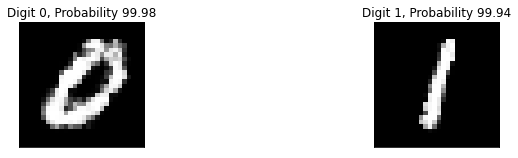

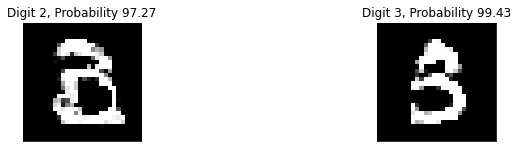

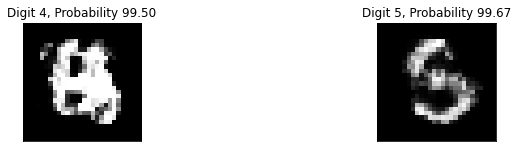

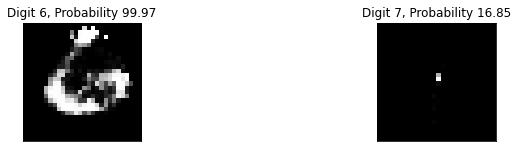

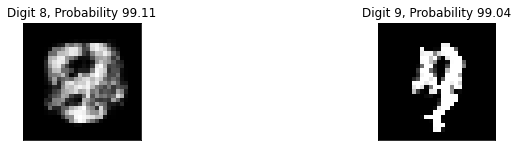

In [54]:
images = []
probabilities = []

for i in range(10):
    img = mnist_data_loader.generate_mean_image_for_class(i).expand(1, 28, 28)
    mean = mnist_data_loader.generate_mean_image_for_class(i).expand(1, 1, 28, 28).to(device)

    interpretor = ActivationMaximizationCodespace(classifier, classes, None, img_shape, i,  lr, reg_term, epochs, generator, latent_dim, mean, threshold=0.99)
    end_point = interpretor.interpret()
    end_point = (end_point - end_point.min()) / (end_point.max() - end_point.min())
    
    scores = model(end_point.to(device)).to(device)
    prob = torch.nn.functional.softmax(scores, 1)[0][i] * 100
    probabilities.append(prob)
    
    images.append(end_point.detach().cpu().numpy().reshape(28, 28))

MnistVisualizer.display_images_with_probabilities_for_each_class(images, probabilities)

## 2. Pretrained DCGAN

In the second and final case, we are using a pretrained DCGAN model that we have found online. The source of this model is the following repository: https://github.com/csinva/gan-vae-pretrained-pytorch.

In [50]:
classifier_name = 'model_cnn.pt'
classifier = ModelRepository.get_general_mnist_cnn(classifier_name)

dcgan_generator = ModelRepository.get_pretrained_dcgan_generator()
dcgan_generator.train()

PretrainedDCGANGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13)

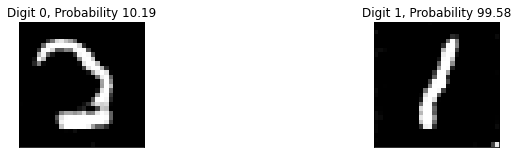

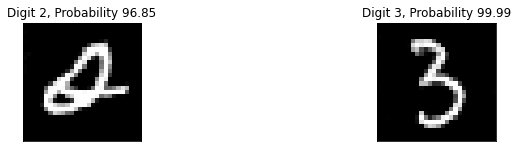

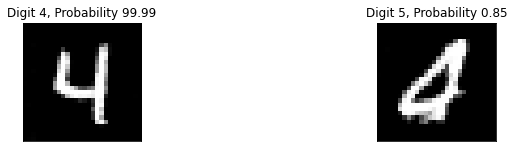

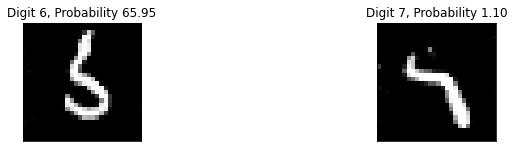

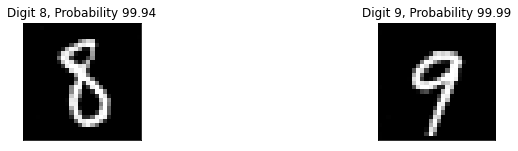

In [51]:
lr = 5e-2
epochs = 10000
reg_term = 1e-2
latent_dim = 100
img_shape = (1, 28, 28)
classes = [str(i) for i in range(10)]

images = []
probabilities = []

for i in range(10):
    img = mnist_data_loader.generate_mean_image_for_class(i).expand(1, 28, 28)
    mean = mnist_data_loader.generate_mean_image_for_class(i).expand(1, 1, 28, 28).to(device)

    interpretor = ActivationMaximizationCodespace(classifier, classes, None, img_shape, i,  lr, reg_term, epochs, dcgan_generator, latent_dim, mean, threshold=0.99, verbose=False, is_dcgan=True)
    end_point = interpretor.interpret()
    end_point = (end_point - end_point.min()) / (end_point.max() - end_point.min())
    
    scores = model(end_point.to(device)).to(device)
    prob = torch.nn.functional.softmax(scores, 1)[0][i] * 100
    probabilities.append(prob)
    
    images.append(end_point.detach().cpu().numpy().reshape(28, 28))

MnistVisualizer.display_images_with_probabilities_for_each_class(images, probabilities)